Parts of code were taken from this sources:

https://towardsdatascience.com/fine-tuning-pre-trained-model-vgg-16-1277268c537f
https://github.com/sozykin/dlpython_course/blob/master/computer_vision/cats_and_dogs/cats_and_dogs_cnn.ipynb 


In [1]:
# Import of required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
# For transfer learning
import keras
from keras.applications.vgg16 import VGG16 
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau


In [2]:
# Downloading of a pre-trained VGG16 network without a fully connected layer
# and freezing of its parameters to avoid changes during training
vgg16_conv = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze four convolution blocks   
for layer in vgg16_conv.layers[:15]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg16_conv.layers):
    print(i, layer.name, layer.trainable)
# REFERENCE: https://towardsdatascience.com/fine-tuning-pre-trained-model-vgg-16-1277268c537f

58900480/58889256 [==============================] - 0s 0us/step
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [3]:
# Connect to Google Drive (which contains dataset)
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
# Directory with training dataset
train_dir = '/content/gdrive/MyDrive/cv_automation/training_sets/train_set'
# Directory with validation dataset
val_dir = '/content/gdrive/MyDrive/cv_automation/training_sets/dev_set'
# Directory with testing dataset
test_dir = '/content/gdrive/MyDrive/cv_automation/training_sets/test_set'
# Image width and height (in pixels)
img_width, img_height = 256, 256
#  Size, channels
input_shape = (img_width, img_height, 3)
# Quantity of epochs for training
epochs = 25
# Batch-size
batch_size = 200
# Quantity of images for training
nb_train_samples = 960
# Quantity of images for validation
nb_validation_samples = 320
# Quantity of images for tests
nb_test_samples = 320
# Number of classes
nb_classes = 4


In [5]:
model = Sequential()  # Defining of sequential model
model.add(vgg16_conv) # Using the pre-trained convolutional part of the VGG16 network as the first layer of the model

# A part for classification that will be learning to recognize objects based on new own dataset
model.add(Flatten()) # A layer for converting an array obtained from a previous layer into a flat vector
model.add(Dense(512)) # Fully-connected layer of 512 neurons
model.add(Activation('relu')) # ReLU activation function
model.add(Dropout(0.5)) # Dropout regularization layer with a neuron exclusion chance of 50%
model.add(Dense(128)) # Fully-connected layer of 128 neurons
model.add(Activation('relu')) # ReLU activation function
model.add(Dense(nb_classes)) # Output layer of 5 classes
model.add(Activation('softmax')) # Activation function for multiclass classification

In [13]:
# Using of Adam optimizer and model compilation

from tensorflow.keras.optimizers import Adam 
optm = tf.keras.optimizers.Adam(
    learning_rate=0.0003,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
) 

model.compile(loss='categorical_crossentropy',
              optimizer=optm,
              metrics=['accuracy'])



lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# REFERENCE: https://towardsdatascience.com/fine-tuning-pre-trained-model-vgg-16-1277268c537f


class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.98 and logs.get('val_accuracy')>0.98:
      self.model.stop_training = True

callback = MyCallback()


In [14]:
# Using of Keras generators for class division

datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical')

Found 960 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Found 320 images belonging to 4 classes.


In [15]:
# Start of model training
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[lr_reduce, callback])

Epoch 1/25
4/4 [==============================] - 10s 2s/step - loss: 0.5483 - accuracy: 0.9303 - val_loss: 0.1035 - val_accuracy: 0.9650 - lr: 3.0000e-04
Epoch 2/25
4/4 [==============================] - 8s 2s/step - loss: 0.1217 - accuracy: 0.9671 - val_loss: 0.0678 - val_accuracy: 0.9950 - lr: 3.0000e-04
Epoch 3/25
4/4 [==============================] - 9s 2s/step - loss: 0.0705 - accuracy: 0.9934 - val_loss: 0.0660 - val_accuracy: 0.9800 - lr: 3.0000e-04


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


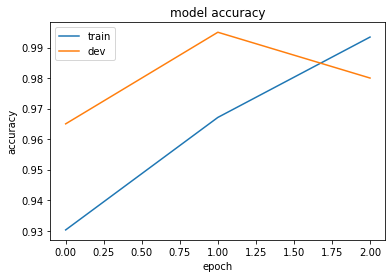

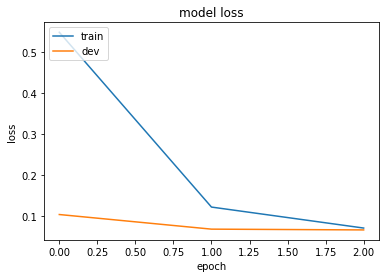

In [16]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

#REFERENCE: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [ ]:
# Saving of trained model on disk
model.save('/content/gdrive/MyDrive/cv_automation/trained_models/adam_00003_ep25_bs_200.h5')

In [ ]:
# Uploading model from disk
from tensorflow.keras.models import load_model
model = load_model('gdrive/MyDrive/adam_00003_ep25_bs_200.h5')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 activation_1 (Activation)   (None, 128)               0

In [ ]:
# Evaluating the accuracy of the network using a test generator
result = model.evaluate(test_generator)
print("Accuracy on test dataset: %.2f%%" % (result[1]*100))

2/2 [==============================] - 45s 41s/step - loss: 2.2799e-05 - accuracy: 1.0000
Accuracy on test dataset: 100.00%


In [ ]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
# Save TFLite model
with open('/content/gdrive/MyDrive/cv_automation/trained_models/model_adam_v01.tflite', 'wb') as f:
  f.write(tflite_model)